In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam


## Function for Filtering

In [2]:
from scipy.signal import butter, filtfilt

def butter_bandpass(data,lowcut, highcut, fs, order=5,padlen=150):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data,padlen=padlen)
    return y

# Generate the Training Data Set 

In [3]:
np.random.seed(13)
nsamp=1200000
thk_min=3    # Minimum thickness measured in samples (dt=1 ms)
thk_mode=5   # modal thickness
thk_max=10   # max thickness
fhcut=80     # high cut for feature vector
flcut=8      # low cut for feature vector
lhcut=300    # high cut for label vector
llcut=3      # low cut for label vector
fs=1000      # sampling freq ---> 1 ms
scMax=5000   # upper limit scale factor
scMin=-5000  # lower limit scale factor  
ntrace=1000  # no sample per trace


## define impedance list
impval=np.int32(np.array(np.linspace(4000,12000,(12000-4000+1))))
imp=np.random.choice(impval,nsamp)


layer_thickness=np.int32(np.random.triangular(thk_min,thk_mode,thk_max,nsamp))

thk_prof=np.cumsum(layer_thickness)
thk_Total=thk_prof[-1]


ref=np.zeros(thk_Total)
##calculate reflectivity series ---> ref=(z2-z1)/(z2+z1)
for ii in range(nsamp-1):
    ref_temp=(imp[ii+1]-imp[ii])/(imp[ii+1]+imp[ii])
    ref[thk_prof[ii]]=ref_temp  

arrlen=len(ref)
ref_rem=arrlen%ntrace

ref_use=arrlen-ref_rem
ref=ref[0:ref_use]
print(ref.shape)

    # Generate the seismic data high resolution pair
seismic=butter_bandpass(ref,flcut, fhcut, fs, order=5)
labels=butter_bandpass(ref,llcut, lhcut, fs, order=5)

(6600000,)


## Plot the Data

Text(0.5, 0, 'amp')

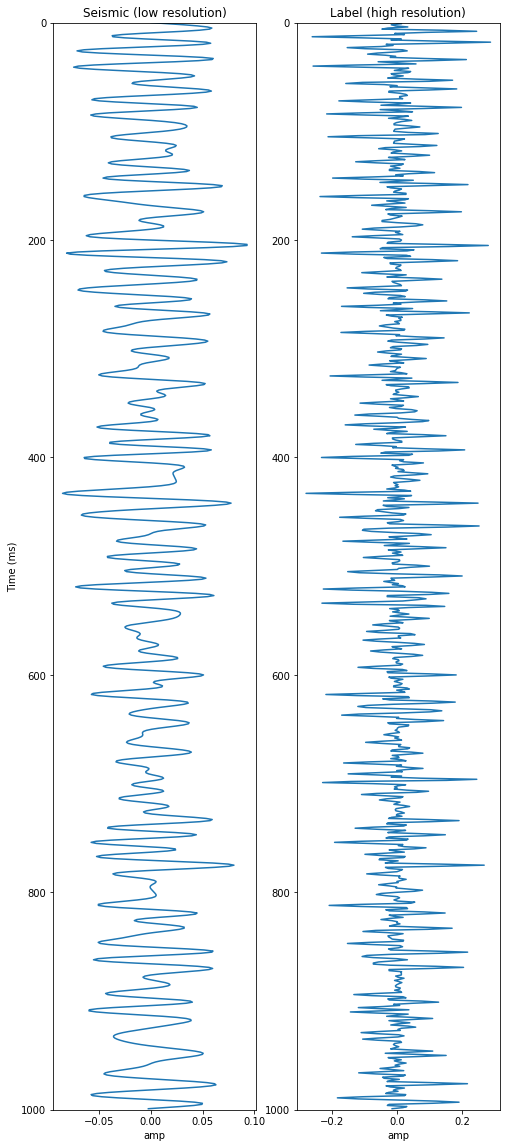

In [4]:
# Plot the data

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(8, 20)) 
ax1.plot(seismic[0:1000], np.array(range(1000)))
ax1.set_title('Seismic (low resolution)')
ax1.set_ylim((0,1000)[::-1])
ax1.set_ylabel('Time (ms)')
ax1.set_xlabel('amp')
ax2.plot(labels[0:1000], np.array(range(1000)))
ax2.set_title('Label (high resolution)')
ax2.set_ylim((0,1000)[::-1])
ax2.set_xlabel('amp')

## Split and Format Data

In [5]:
## Normalize the data
seismic=scMin +(seismic-np.min(seismic))*(scMax-scMin)/(np.max(seismic)-np.min(seismic))
labels=scMin +(labels-np.min(labels))*(scMax-scMin)/(np.max(labels)-np.min(labels))

X_train, X_test, y_train, y_test = train_test_split(seismic, labels, test_size=0.25, random_state=42)

In [6]:
x_train=np.reshape(X_train,(-1,1000))
x_test=np.reshape(X_test,(-1,1000))
y_train=np.reshape(y_train,(-1,1000))
y_test=np.reshape(y_test,(-1,1000))

x_train=np.expand_dims(x_train, axis=-1)
y_train=np.expand_dims(y_train, axis=-1)
x_train=np.expand_dims(x_train, axis=-1)
y_train=np.expand_dims(y_train, axis=-1)

## Import Ancilliary Functions

In [7]:
sys.path.append(r'E:\PythEnv')
from resnet_model3 import resnet_v1, lr_schedule
#from schedule_lr import lr_schedule
#from unet_model import UNet


## Build the ResNet model 

In [8]:
DEPTH=20
batch_size=32
epochs=2000
nrow,ncol,c1,c2=x_train.shape
input_shape=(ncol,c1,c2)

model = resnet_v1(input_shape=input_shape,depth=DEPTH,num_classes=ncol,
                 num_filters=16, nstack=3, kernel_size=(3,1), pool_size=(2,1))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 1, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1000, 1, 16)  64          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 1000, 1, 16)  0           conv2d[0][0]                     
________________________________________________________________________________________

## Compile and Run 

In [ ]:
start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

#model.compile(loss='mean_squared_error',optimizer=Adam(lr=lr_schedule(0)), metrics=["mean_squared_error"])
model.compile(loss='mean_squared_error',optimizer=Adam(lr=lr_schedule(0)), metrics=["mean_squared_error"])

model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.1,verbose=2,
          shuffle=True,initial_epoch=0,callbacks=callbacks)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


Learning rate:  0.01
Train on 4455 samples, validate on 495 samples
Learning rate:  0.01
Epoch 1/2000
4455/4455 - 31s - loss: 795054.1648 - mean_squared_error: 795054.1250 - val_loss: 707720.5076 - val_mean_squared_error: 707720.5000
Learning rate:  0.01
Epoch 2/2000
4455/4455 - 30s - loss: 705806.3487 - mean_squared_error: 705806.2500 - val_loss: 704895.0426 - val_mean_squared_error: 704895.0625
Learning rate:  0.01
Epoch 3/2000
4455/4455 - 30s - loss: 703455.2977 - mean_squared_error: 703455.3750 - val_loss: 705405.4162 - val_mean_squared_error: 705405.3125
Learning rate:  0.01
Epoch 4/2000
4455/4455 - 30s - loss: 703140.8900 - mean_squared_error: 703140.9375 - val_loss: 704281.2563 - val_mean_squared_error: 704281.1875
Learning rate:  0.01
Epoch 5/2000
4455/4455 - 30s - loss: 702232.3370 - mean_squared_error: 702232.6250 - val_loss: 701580.2588 - val_mean_squared_error: 701580.3125
Learning rate:  0.01
Epoch 6/2000
4455/4455 - 30s - loss: 702164.3744 - mean_squared_error: 702164.187